<a href="https://colab.research.google.com/github/alfredqbit/datasciencecoursera/blob/master/sepulvedaADDS-8515-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Factor Analysis and Logistic Regression on the Consumer Behavior Dataset

This notebook applies Factor Analysis (FA) to the Consumer Behavior dataset. We perform preprocessing,
factor extraction and rotation, and evaluate how FA impacts machine learning model performance.

In [71]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Create figures directory
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

Step 1: Dataset Selection, Loading, and Exploratory Data Analysis (EDA)

In [72]:
import ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)

# data (as pandas dataframes)
X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets

# metadata
print(online_shoppers_purchasing_intention_dataset.metadata)

# variable information
print(online_shoppers_purchasing_intention_dataset.variables)

# Extract feature names from the dataset variables
feature_names = online_shoppers_purchasing_intention_dataset.variables[online_shoppers_purchasing_intention_dataset.variables['role'] == 'Feature']['name'].tolist()

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Show basic information
df.head(), df.describe(), df.isnull().sum(), df['target'].value_counts()

{'uci_id': 468, 'name': 'Online Shoppers Purchasing Intention Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/468/data.csv', 'abstract': 'Of the 12,330 sessions in the dataset,\n84.5% (10,422) were negative class samples that did not\nend with shopping, and the rest (1908) were positive class\nsamples ending with shopping.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 12330, 'num_features': 17, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Revenue'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5F88Q', 'creators': ['C. Sakar', 'Yomi Kastro'], 'intro_paper': {'ID': 367, 'type': 'NATIVE', 'title': 'Real-time prediction of online shoppers’ pur

(   Administrative  Administrative_Duration  Informational  \
 0               0                      0.0              0   
 1               0                      0.0              0   
 2               0                      0.0              0   
 3               0                      0.0              0   
 4               0                      0.0              0   
 
    Informational_Duration  ProductRelated  ProductRelated_Duration  \
 0                     0.0               1                 0.000000   
 1                     0.0               2                64.000000   
 2                     0.0               1                 0.000000   
 3                     0.0               2                 2.666667   
 4                     0.0              10               627.500000   
 
    BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
 0         0.20       0.20         0.0         0.0   Feb                 1   
 1         0.00       0.10         0.0    

Step 2: Data Preprocessing and Feature Engineering

In [73]:
# Identify categorical and boolean columns that need encoding
categorical_cols = df.select_dtypes(include='object').columns
boolean_cols = df.select_dtypes(include='bool').columns

# Create a copy of the dataframe to avoid modifying the original 'df' directly
df_processed = df.copy()

# Convert boolean columns to integers (0s and 1s)
for col in boolean_cols:
    df_processed[col] = df_processed[col].astype(int)

# Apply one-hot encoding to categorical columns
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y_processed) from the processed DataFrame
X_processed = df_processed.drop(columns='target')
y_processed = df_processed['target']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

# Update feature names to include one-hot encoded columns
processed_feature_names = X_processed.columns.tolist()

# Check standardized data
pd.DataFrame(X_scaled, columns=processed_feature_names).head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175,-0.083316,0.410621
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175,-0.083316,0.410621
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175,-0.083316,0.410621
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175,-0.083316,0.410621
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175,-0.083316,0.410621


Step 3: Conduct Factor Analysis

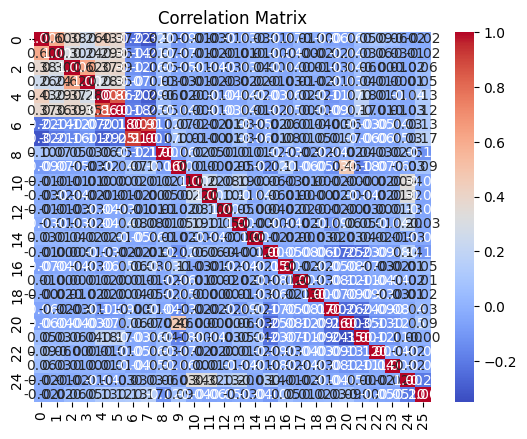

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
0,0.384606,0.272347,0.251508,0.183705,0.476400,0.447679,-0.903482,-0.945315,0.161623,-0.099785,...,-0.084078,-0.005285,-0.040713,-0.032832,-0.086850,0.093710,0.055837,0.047712,-0.039722,-0.115212
1,0.310896,0.280855,0.365868,0.320608,0.787188,0.811393,0.281491,0.205377,-0.019468,0.007853,...,-0.018304,0.016905,0.032137,-0.103564,-0.040377,0.163402,-0.026549,-0.016813,-0.025015,0.216277
2,0.001379,0.000244,-0.013915,-0.009750,0.008236,0.009322,0.011027,-0.004872,0.104771,-0.060012,...,-0.044926,-0.017833,-0.000850,-0.104654,-0.079860,0.022103,-0.019371,-0.007453,0.702898,-0.231291


In [74]:
# Check correlation matrix
correlation_matrix = np.corrcoef(X_scaled.T)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.savefig(os.path.join(FIG_DIR, 'correlation_matrix.png'))
plt.show()

# Perform Factor Analysis
fa = FactorAnalysis(n_components=3)
fa.fit(X_scaled)

# Factor loadings
loadings_df = pd.DataFrame(fa.components_, columns=processed_feature_names)
loadings_df

Step 4: Data Visualization and Interpretation

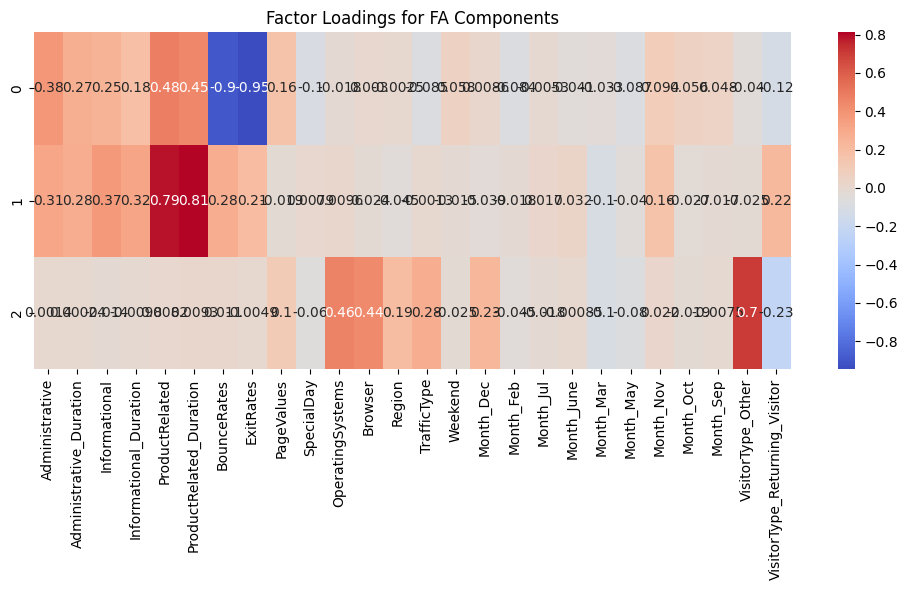

In [75]:
# Plot the factor loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
plt.title('Factor Loadings for FA Components')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'factor_loadings.png'))
plt.show()

Step 5: Machine Learning Model on Original Features (LR)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert y_train and y_test to 1D arrays to suppress DataConversionWarning
y_train_raveled = y_train.values.ravel()
y_test_raveled = y_test.values.ravel()

# Logistic Regression pipeline on original features
baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

t0 = time.time()
baseline_pipeline.fit(X_train, y_train_raveled)
t1 = time.time()

y_pred_baseline = baseline_pipeline.predict(X_test)

print(f"Baseline model accuracy: {accuracy_score(y_test_raveled, y_pred_baseline)}")
print("Classification report:")
print(classification_report(y_test_raveled, y_pred_baseline))
print(f"Training time (s): {t1 - t0}")

Baseline model accuracy: 0.8730738037307381
Classification report:
              precision    recall  f1-score   support

       False       0.88      0.98      0.93      2055
        True       0.76      0.35      0.48       411

    accuracy                           0.87      2466
   macro avg       0.82      0.66      0.70      2466
weighted avg       0.86      0.87      0.85      2466

Training time (s): 0.034476280212402344


Step 6: Apply Factor Analysis to Transform Data

In [77]:
X_fa = fa.transform(X_scaled)

Step 7: Train Model on FA-transformed Data

In [78]:
# Logistic Regression pipeline on FA-transformed features
pca_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("fa", FactorAnalysis(n_components=3)),  # Same number of components
    ("clf", LogisticRegression(max_iter=1000))
])

t0 = time.time()
pca_pipeline.fit(X_train, y_train_raveled)
t1 = time.time()

y_pred_fa = pca_pipeline.predict(X_test)

print(f"FA-transformed model accuracy: {accuracy_score(y_test_raveled, y_pred_fa)}")
print("Classification report:")
print(classification_report(y_test_raveled, y_pred_fa))
print(f"Training time (s): {t1 - t0}")

FA-transformed model accuracy: 0.8341443633414436
Classification report:
              precision    recall  f1-score   support

       False       0.84      1.00      0.91      2055
        True       0.60      0.01      0.03       411

    accuracy                           0.83      2466
   macro avg       0.72      0.51      0.47      2466
weighted avg       0.80      0.83      0.76      2466

Training time (s): 2.1974902153015137


Step 8: Compare Performance Before and After FA

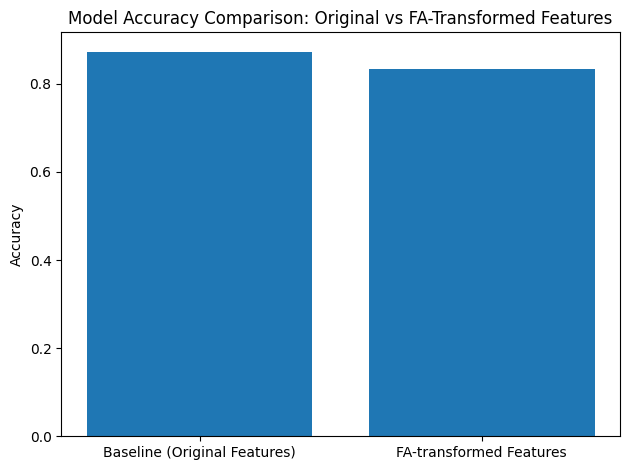

In [79]:
# Accuracy comparison
results = pd.DataFrame({
    "Model": ["Baseline (Original Features)", "FA-transformed Features"],
    "Accuracy": [accuracy_score(y_test, y_pred_baseline), accuracy_score(y_test, y_pred_fa)],
})

# Save the results as PNG and CSV
results.to_csv(os.path.join(FIG_DIR, 'results_table.csv'), index=False)

# Bar chart comparison
plt.figure()
plt.bar(results["Model"], results["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison: Original vs FA-Transformed Features")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'accuracy_comparison.png'))
plt.show()